In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

from diffdrr import DRR, load_example_ct
from diffdrr.metrics import XCorr2
from diffdrr.visualization import plot_drr

from loss import GenLoss

tensor([3.1416, 0.0000, 1.5708], device='cuda:0')
tensor([180.0000, 180.0000, 166.2500], device='cuda:0', dtype=torch.float64)


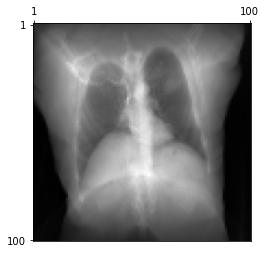

In [2]:
# Read in the volume
volume, spacing = load_example_ct()

# Get the true parameters for the detector
sdr = 200.0
true_rotations = torch.tensor([torch.pi, 0, torch.pi / 2]).cuda()
true_translations = (torch.tensor(volume.shape) * torch.tensor(spacing) / 2).cuda()

# Make the DRR
drr = DRR(volume, spacing, height=100, delx=5e-2, device="cuda")
img = drr.project(sdr, true_rotations, true_translations)

# Look at the ground truth
print(true_rotations)
print(true_translations)
plot_drr(img)
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self, rotation=False, dtype=torch.float32, device="cuda"):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5, dtype=dtype, device=device)
        self.conv2 = torch.nn.Conv2d(6, 16, 5, dtype=dtype, device=device)
        self.pool = torch.nn.MaxPool2d(2)
        self.norm1 = torch.nn.BatchNorm2d(6, dtype=dtype, device=device)
        self.norm2 = torch.nn.BatchNorm2d(16, dtype=dtype, device=device)
        self.fc1 = torch.nn.Linear(16 * 22 * 22, 120, dtype=dtype, device=device)
        self.fc2 = torch.nn.Linear(120, 84, dtype=dtype, device=device)
        self.fc3 = torch.nn.Linear(84, 3, dtype=dtype, device=device)
        self.rotation = rotation

    def forward(self, x):
        x = x.view(-1, 1, 100, 100)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.norm1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.norm2(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if self.rotation:
            x = torch.remainder(x, 2 * torch.pi)
        return x

    def num_flat_features(self, x):
        return torch.tensor(x.shape[1:]).prod().item()

In [4]:
class GenLoss(nn.Module):
    def __init__(self, drr, sdr=200.0, zero_mean_normalized=True):
        super(GenLoss, self).__init__()
        self.drr = drr
        self.sdr = sdr
        self.xcorr2 = XCorr2(zero_mean_normalized)

    def forward(self, est_rotations, est_translations, true_rotations, true_translations):
        est_drr = self.drr.project(self.sdr, est_rotations[0], est_translations[0])
        true_drr = self.drr.project(self.sdr, true_rotations, true_translations)
        loss = -self.xcorr2(true_drr, est_drr)
        return loss, est_drr, true_drr

In [7]:
# Initialize loss and model
model_rotations = Model(rotation=True)
model_rotations.train(True)
model_translations = Model()
model_translations.train(True)

opt_rotations = optim.SGD(model_rotations.parameters(), lr=3e-2, momentum=0.5)
opt_translations = optim.SGD(model_translations.parameters(), lr=3e-2, momentum=0.5)
loss_func = GenLoss(drr)

In [8]:
for epoch in range(10_000):
    # Zero the gradient for each batch
    opt_rotations.zero_grad()
    opt_translations.zero_grad()

    # Make predictions of the batch
    est_rotations = model_rotations(img)
    est_translations = model_translations(img)
    # print(est_rotations.detach().cpu(), est_translations.detach().cpu())

    # Compute loss and its gradient
    loss, est_drr, true_drr = loss_func(est_rotations, est_translations, true_rotations, true_translations)
    loss.backward(retain_graph=True)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}:", loss.item())

    # Adjust the weights
    opt_rotations.step()
    opt_translations.step()

Epoch 0: 0.21076515316963196
Epoch 100: 0.029311107471585274
Epoch 200: 0.02340926229953766
Epoch 300: -0.17908622324466705
Epoch 400: -0.1724066436290741
Epoch 500: -0.17472435534000397
Epoch 600: -0.1318281888961792
Epoch 700: -0.18241891264915466
Epoch 800: -0.17158158123493195
Epoch 900: -0.19749405980110168
Epoch 1000: -0.18158163130283356
Epoch 1100: -0.16965177655220032
Epoch 1200: -0.2749881446361542
Epoch 1300: -0.33835098147392273
Epoch 1400: -0.3092253804206848
Epoch 1500: -0.3130161166191101
Epoch 1600: -0.36498570442199707
Epoch 1700: -0.30461862683296204
Epoch 1800: -0.3555980622768402
Epoch 1900: -0.31971707940101624
Epoch 2000: -0.3497631251811981
Epoch 2100: -0.3819566071033478
Epoch 2200: -0.31236281991004944
Epoch 2300: -0.40678921341896057
Epoch 2400: -0.4798479974269867
Epoch 2500: -0.5138585567474365
Epoch 2600: -0.5244314670562744
Epoch 2700: -0.3995801508426666
Epoch 2800: -0.522703230381012
Epoch 2900: -0.5376192331314087
Epoch 3000: -0.5422836542129517
Epoch 3

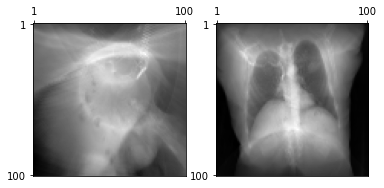

In [9]:
fig, axs = plt.subplots(ncols=2)
plot_drr(est_drr, ax=axs[0])
plot_drr(true_drr, ax=axs[1])
plt.show()